Aims to predict final grading using regression from groups of students who took Math course and Portuguese course respectively in 2 different schools, "GP" and "MS"

**Used Library**

In [1]:
library(ggplot2) #plotting visualization
library(tidyverse)
library(randomForest) #rf
library(ggpubr) # graphical arrangement
library(caTools) #train test split
library(data.table)
library(caret)
library(glmnet) #determine lambda for ridge

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
✔ purrr   1.0.1      
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    p

In [2]:
Port_course = read.csv("/kaggle/input/student-performance-data-set/student-por.csv",sep=",",header=TRUE)
Math_course = read.csv("/kaggle/input/math-students/student-mat.csv",sep=",",header=TRUE)

colnames(Port_course)
colnames(Math_course)

[1] "school"     "sex"        "age"        "address"    "famsize"   
 [6] "Pstatus"    "Medu"       "Fedu"       "Mjob"       "Fjob"      
[11] "reason"     "guardian"   "traveltime" "studytime"  "failures"  
[16] "schoolsup"  "famsup"     "paid"       "activities" "nursery"   
[21] "higher"     "internet"   "romantic"   "famrel"     "freetime"  
[26] "goout"      "Dalc"       "Walc"       "health"     "absences"  
[31] "G1"         "G2"         "G3"

[1] "school"     "sex"        "age"        "address"    "famsize"   
 [6] "Pstatus"    "Medu"       "Fedu"       "Mjob"       "Fjob"      
[11] "reason"     "guardian"   "traveltime" "studytime"  "failures"  
[16] "schoolsup"  "famsup"     "paid"       "activities" "nursery"   
[21] "higher"     "internet"   "romantic"   "famrel"     "freetime"  
[26] "goout"      "Dalc"       "Walc"       "health"     "absences"  
[31] "G1"         "G2"         "G3"

**Data wrangling and cleaning**

In [3]:
#list of nominal variables that we want to factories for one-hot
column_names = c("school","sex","address","famsize","Pstatus","Mjob","Fjob","reason","guardian","schoolsup","famsup","paid","activities","nursery","higher","internet","romantic")

#discard G1 and G2
new_math <- subset(Math_course, select= -c(G1,G2))
new_port <- subset(Port_course, select= -c(G1,G2))
rm(Math_course)
rm(Port_course)




In [4]:
#factor the nominal variables
#math
for (i in names(new_math)) {
  
  if (i %in% column_names) {
    
    new_math[,i] <- as.factor(new_math[,i])
  } else {
    
    new_math[,i] <- new_math[,i]
  }
}
#port
for (i in names(new_port)) {
 
  if (i %in% column_names) {
    
    new_port[,i] <- as.factor(new_port[,i])
  } else {
    
    new_port[,i] <- new_port[,i]
  }
}

print(head(new_math))

  school sex age address famsize Pstatus Medu Fedu     Mjob     Fjob     reason
1     GP   F  18       U     GT3       A    4    4  at_home  teacher     course
2     GP   F  17       U     GT3       T    1    1  at_home    other     course
3     GP   F  15       U     LE3       T    1    1  at_home    other      other
4     GP   F  15       U     GT3       T    4    2   health services       home
5     GP   F  16       U     GT3       T    3    3    other    other       home
6     GP   M  16       U     LE3       T    4    3 services    other reputation
  guardian traveltime studytime failures schoolsup famsup paid activities
1   mother          2         2        0       yes     no   no         no
2   father          1         2        0        no    yes   no         no
3   mother          1         2        3       yes     no  yes         no
4   mother          1         3        0        no    yes  yes        yes
5   father          1         2        0        no    yes  yes        

**Train test split**

In [5]:
set.seed(2022)
#split for math course
train_math <- sample.split(Y=new_math$G3, SplitRatio = 0.7)

#split for port course
train_port <- sample.split(Y=new_port$G3, SplitRatio = 0.7)

#subset train-test math course with categorical nominal variables
trainset_math <- subset(new_math, train_math ==T)
testset_math <-subset(new_math, train_math ==F)


#subset train-test port course with categorical nominal variables
trainset_port <- subset(new_port, train_port ==T)
testset_port<-subset(new_port, train_port ==F)


# Linear regression

In [6]:

M.linear <- lm(G3 ~ ., data = trainset_math)
P.linear <- lm(G3 ~ ., data = trainset_port)
#create a namelist for comparison results later
model <- ("Linear Reg")
print(M.linear)


Call:
lm(formula = G3 ~ ., data = trainset_math)

Coefficients:
     (Intercept)          schoolMS              sexM               age  
        17.58974           0.22211           1.15614          -0.46294  
        addressU        famsizeLE3          PstatusT              Medu  
         0.36443           0.93567          -1.32050           0.55551  
            Fedu        Mjobhealth         Mjobother      Mjobservices  
        -0.50717           0.90291          -0.72109           0.89504  
     Mjobteacher        Fjobhealth         Fjobother      Fjobservices  
        -0.92080           3.14803           0.87933           1.32386  
     Fjobteacher        reasonhome       reasonother  reasonreputation  
         2.70326          -0.13733           0.59373           0.55986  
  guardianmother     guardianother        traveltime         studytime  
        -0.19911           0.59405          -0.10706           0.41407  
        failures      schoolsupyes         famsupyes       

**caculate RMSE of test**

In [7]:
RMSE.test.M <- round(sqrt(mean((testset_math$G3 - predict(M.linear, newdata = testset_math))^2)),2)
M.predict.L <- data.frame(predict(M.linear, newdata= testset_math) , testset_math$G3)
names(M.predict.L)[1] <-"new_predicted_G3"

RMSE.test.P <- round(sqrt(mean((testset_port$G3 - predict(P.linear, newdata = testset_port))^2)),2)
P.predict.L <- data.frame(predict(P.linear, newdata= testset_port) , testset_port$G3)
names(P.predict.L)[1] <-"new_predicted_G3"


**plot linear regression**

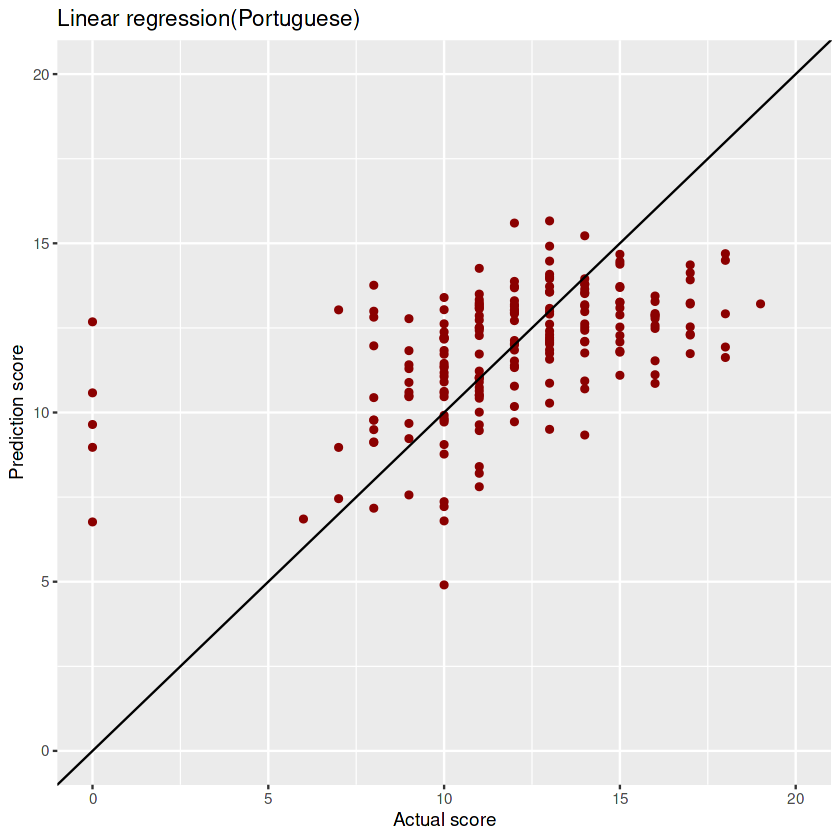

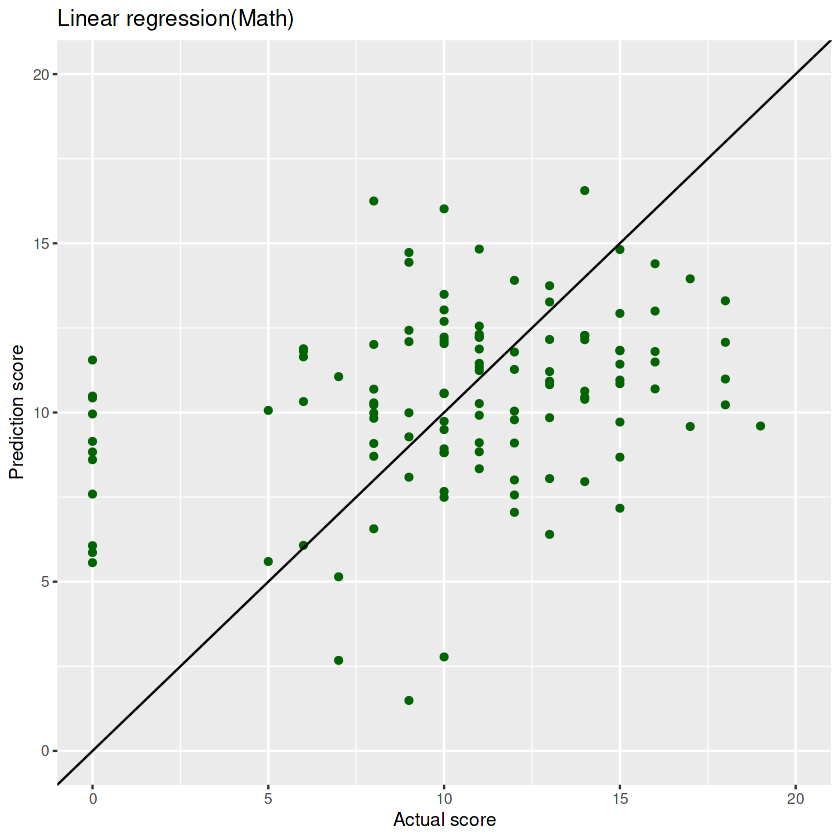

In [8]:
ggplot(data=P.predict.L,aes(x= testset_port.G3, y=new_predicted_G3))+
                geom_point(color="darkred")+
                geom_abline(colour ="black")+
                xlab("Actual score")+
                ylab("Prediction score")+
                xlim(0,20)+
                ylim(0,20)+
                ggtitle("Linear regression(Portuguese)")

ggplot(data=M.predict.L,aes(x= testset_math.G3, y=new_predicted_G3))+
                geom_point(color="darkgreen")+
                geom_abline(colour ="black")+
                xlab("Actual score")+
                ylab("Prediction score")+
                xlim(0,20)+
                ylim(0,20)+
                ggtitle("Linear regression(Math)")


# Ridge regression

obtain matrix for ridge and determining the best lambda


In [9]:
#best lambda for maths
x.math <-model.matrix(G3~.,trainset_math)[,-1]
cv.math <-cv.glmnet(x.math,trainset_math$G3,alpha=0)
cv.math$lambda.min #min lambda value 

# best lambda for port
x.port <-model.matrix(G3~.,trainset_port)[,-1]
cv.port <-cv.glmnet(x.port,trainset_port$G3,alpha=0)
cv.port$lambda.min #min lambda value

[1] 4.333794

[1] 1.371061

**Ridge Model**

In [10]:
ridge_math <- glmnet(x.math,trainset_math$G3,alpha=0,lambda= cv.math$lambda.min)
ridge_port <- glmnet(x.port,trainset_port$G3,alpha=0,lambda= cv.port$lambda.min)

#prediction dataframe
#math
xtest.math <- model.matrix(G3~.,testset_math)[,-1]
ridge.pred.math <- as.vector(predict(ridge_math,xtest.math))
#port
xtest.port <- model.matrix(G3~.,testset_port)[,-1]
ridge.pred.port <- as.vector(predict(ridge_port,xtest.port))


#RMSE
model <-c(model,"ridge")
RMSE.test.M <- c(RMSE.test.M, round(sqrt(mean((testset_math$G3 - ridge.pred.math))^2),2))
RMSE.test.P <- c(RMSE.test.P, round(sqrt(mean((testset_port$G3 - ridge.pred.port))^2),2))


**plot ridge regression**

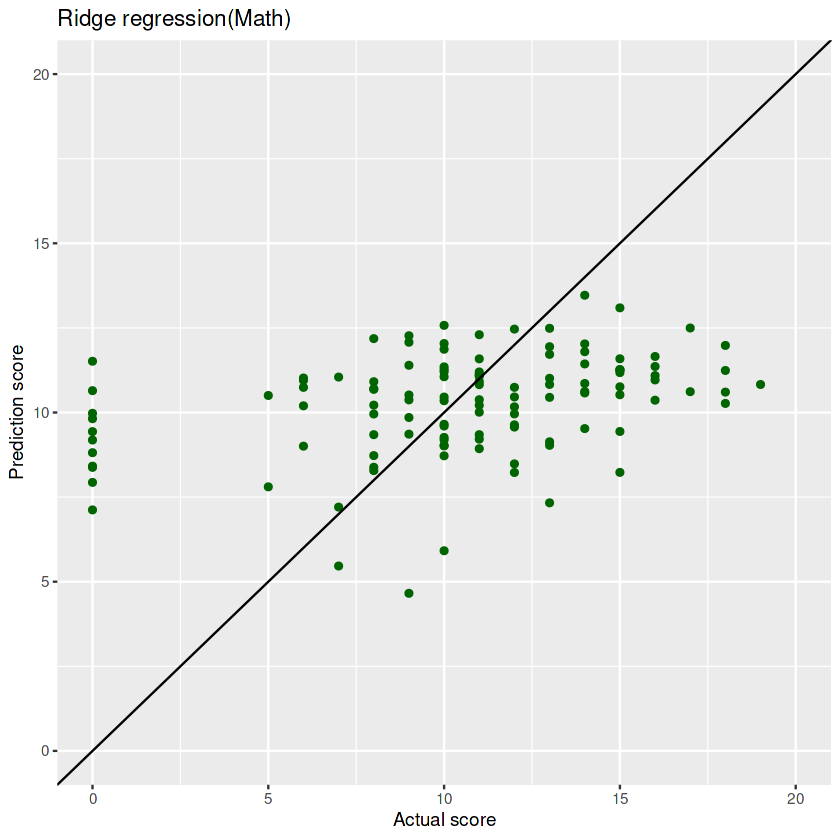

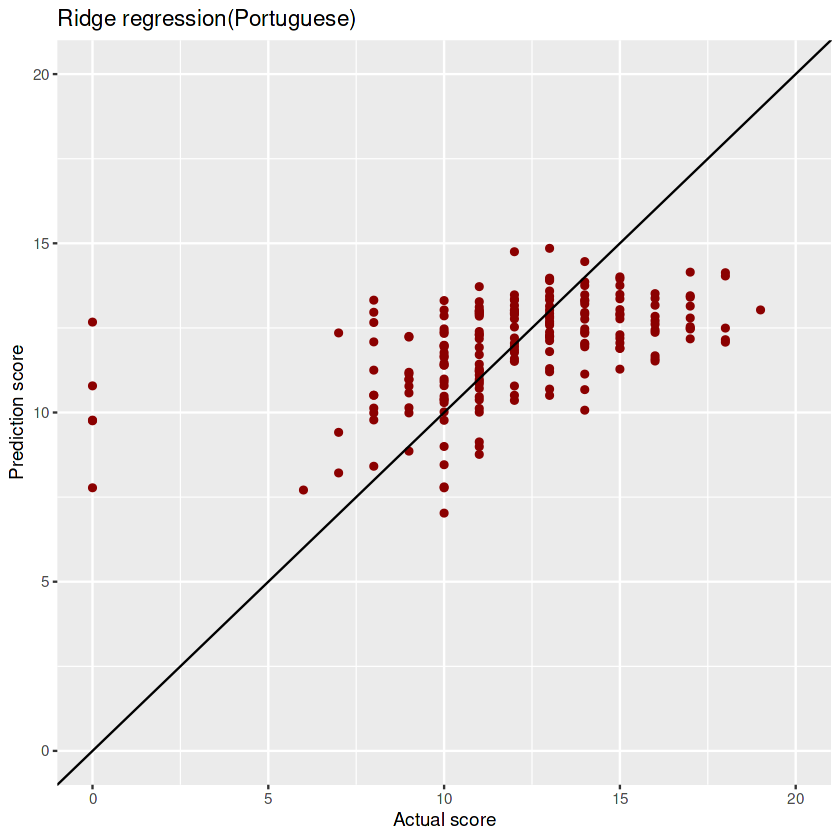

In [11]:
#create a df for plotting
ridge.math.plt <- data.frame(ridge.pred.math,testset_math$G3)
ridge.port.plt <- data.frame(ridge.pred.port,testset_port$G3)

#plot
ggplot(ridge.math.plt,aes(x= testset_math.G3, y=ridge.pred.math))+
  geom_point(color="darkgreen")+
  geom_abline(colour ="black")+
  xlab("Actual score")+
  ylab("Prediction score")+
  xlim(0,20)+
  ylim(0,20)+
  ggtitle("Ridge regression(Math)")

ggplot(ridge.port.plt,aes(x= testset_port.G3, y=ridge.pred.port))+
  geom_point(color="darkred")+
  geom_abline(colour ="black")+
  xlab("Actual score")+
  ylab("Prediction score")+
  xlim(0,20)+
  ylim(0,20)+
  ggtitle("Ridge regression(Portuguese)")


# Random Forest

In [12]:
#MATH
M.RF <- randomForest(G3 ~ . , data=trainset_math)
#PORT
P.RF <- randomForest(G3 ~ . , data=trainset_port)

print(M.RF)
print(P.RF)

## Confirms error stabled before 500 trees.
model <- c(model, "Random Forest")

#A new data for RMSE prediction, prevents Out of bag prediciton
RMSE.test.M <- c(RMSE.test.M, round(sqrt(mean((testset_math$G3 - predict(M.RF, newdata = testset_math))^2)),2))
RMSE.test.P <- c(RMSE.test.P, round(sqrt(mean((testset_port$G3 - predict(P.RF, newdata = testset_port))^2)),2))

#prediction model
P.predict.RF <- data.frame(predict(P.RF, newdata= testset_port) , testset_port$G3)
names(P.predict.RF)[1] <-"RF_predicted_G3"
M.predict.RF <- data.frame(predict(M.RF, newdata= testset_math) , testset_math$G3)
names(M.predict.RF)[1] <-"RF_predicted_G3"




Call:
 randomForest(formula = G3 ~ ., data = trainset_math) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 10

          Mean of squared residuals: 15.56317
                    % Var explained: 26.45

Call:
 randomForest(formula = G3 ~ ., data = trainset_port) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 10

          Mean of squared residuals: 7.209428
                    % Var explained: 30


**Plot random forest regression**

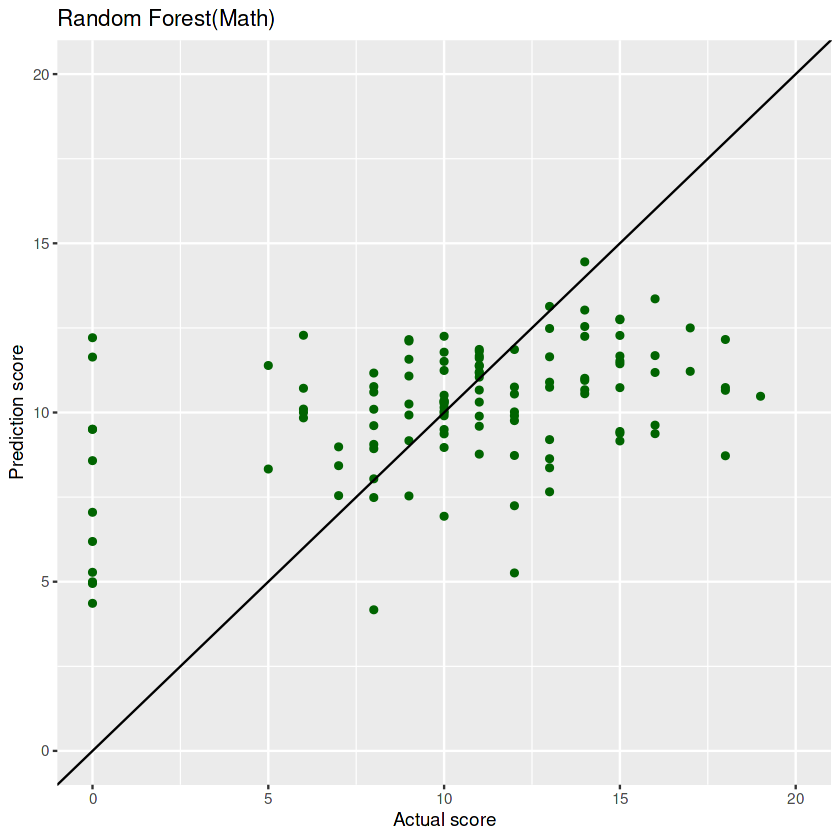

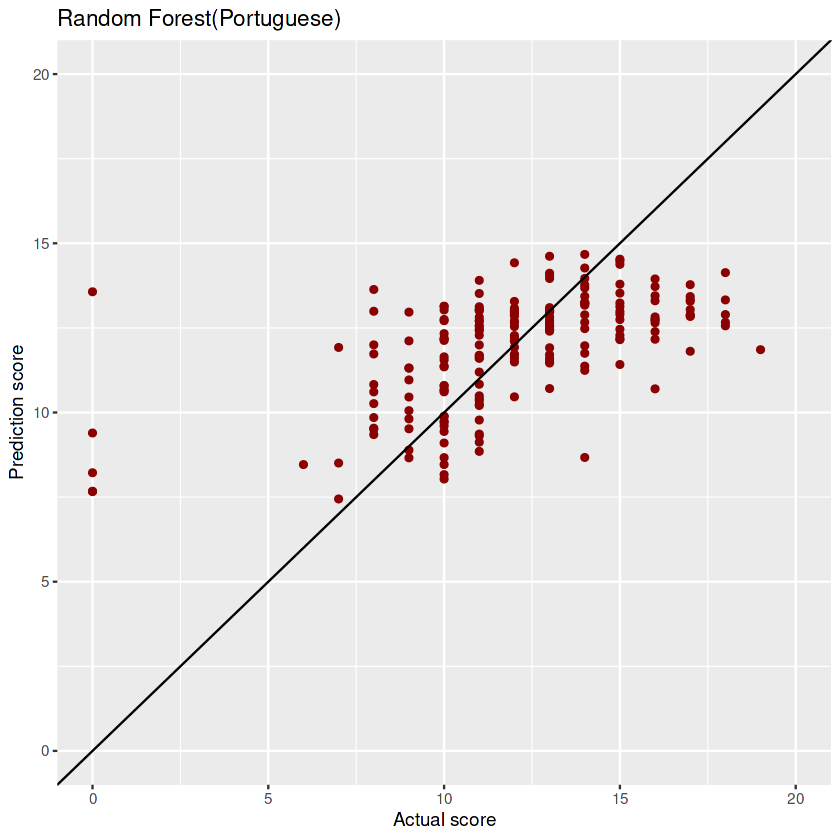

In [13]:
ggplot(data=M.predict.RF,aes(x= testset_math.G3, y=RF_predicted_G3))+
            geom_point(color="darkgreen")+
            geom_abline(colour ="black")+
            xlab("Actual score")+
            ylab("Prediction score")+
            xlim(0,20)+
            ylim(0,20)+
            ggtitle("Random Forest(Math)")

ggplot(data=P.predict.RF,aes(x= testset_port.G3, y=RF_predicted_G3))+
            geom_point(color="darkred")+
            geom_abline(colour ="black")+
            xlab("Actual score")+
            ylab("Prediction score")+
            xlim(0,20)+
            ylim(0,20)+
            ggtitle("Random Forest(Portuguese)")


# create a result table using RMSE of three models and the namelist we created.


In [14]:
result<- data.frame(model,RMSE.test.M,RMSE.test.P)
print(result)

          model RMSE.test.M RMSE.test.P
1    Linear Reg        4.45        2.84
2         ridge        0.15        0.04
3 Random Forest        4.02        2.68


**Results of the 3 different suggest that ridge regression is the most accurate by a huge margine, which proves our visualization of the graph.**

While the graphs shows Math courses are more scattered compare to Portuguese. Meaning Math students’s grade has a higher variation. Thus predictions of Portuguese students are also more accurate than Math.
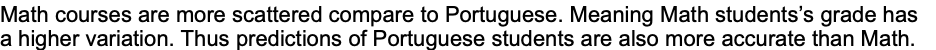
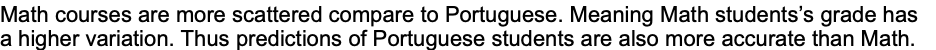
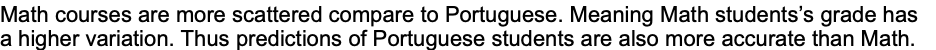
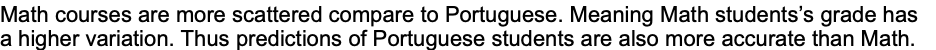